# Relax Take-Home challenge

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Reading the CSV dataframes
engagement_df = pd.read_csv('takehome_user_engagement.csv')
users_df = pd.read_csv("takehome_users.csv", encoding='latin1')

engagement_df.info(), users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_

(None, None)

**Identifying adopted users**

In [3]:
# Convert time_stamp to datetime
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])

# Extract date only to group by day
engagement_df['date'] = engagement_df['time_stamp'].dt.date

# Group by user and get sorted list of unique login dates
user_logins = engagement_df.groupby('user_id')['date'].apply(lambda x: sorted(set(x))).reset_index()

# Function to check if user has 3 logins in a 7-day window
def is_adopted(dates):
    for i in range(len(dates) - 2):
        if (dates[i+2] - dates[i]).days <= 7:
            return 1
    return 0

# Apply the function
user_logins['adopted'] = user_logins['date'].apply(lambda x: is_adopted([pd.to_datetime(d) for d in x]))

# Preview adopted user flags
user_logins.head()

,user_id,date,adopted
0,1,[2014-04-22],0
1,2,"[2013-11-15, 2013-11-29, 2013-12-09, 2013-12-2...",1
2,3,[2013-03-19],0
3,4,[2013-05-22],0
4,5,[2013-01-22],0


**Merging adoption labels with users Metadata**

In [4]:
# Merge the adoption labels with user metadata
merged_df = users_df.merge(user_logins[['user_id', 'adopted']], how='left', left_on='object_id', right_on='user_id')

# Fill users with no engagement data as not adopted (0)
merged_df['adopted'] = merged_df['adopted'].fillna(0).astype(int)

# Drop duplicate user_id column
merged_df.drop(columns='user_id', inplace=True)

# Show merged data summary
merged_df['adopted'].value_counts()

adopted
0    10344
1     1656
Name: count, dtype: int64

Heavy class imbalance of adopted (1656) vs. not-adopted (10,344)

**Feature Engineering**

In [5]:
from datetime import datetime

# Convert creation_time to datetime
merged_df['creation_time'] = pd.to_datetime(merged_df['creation_time'])

# Extract features from creation_time
merged_df['creation_year'] = merged_df['creation_time'].dt.year
merged_df['creation_month'] = merged_df['creation_time'].dt.month
merged_df['creation_day'] = merged_df['creation_time'].dt.day
merged_df['creation_weekday'] = merged_df['creation_time'].dt.weekday

# Convert last_session_creation_time (Unix time) to datetime
merged_df['last_session_creation_time'] = pd.to_datetime(
    merged_df['last_session_creation_time'], unit='s', errors='coerce'
)

# Time delta features
merged_df['days_since_creation'] = (
    (merged_df['last_session_creation_time'] - merged_df['creation_time']).dt.days
)

# Binary flag for whether they were invited by another user
merged_df['was_invited'] = merged_df['invited_by_user_id'].notnull().astype(int)

# One-hot encode creation_source
creation_source_dummies = pd.get_dummies(merged_df['creation_source'], prefix='source')

# Combine everything
feature_df = pd.concat([
    merged_df.drop(columns=[
        'name', 'email', 'creation_time', 'last_session_creation_time',
        'creation_source', 'invited_by_user_id', 'object_id'
    ]),
    creation_source_dummies
], axis=1)



feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   opted_in_to_mailing_list    12000 non-null  int64  
 1   enabled_for_marketing_drip  12000 non-null  int64  
 2   org_id                      12000 non-null  int64  
 3   adopted                     12000 non-null  int32  
 4   creation_year               12000 non-null  int32  
 5   creation_month              12000 non-null  int32  
 6   creation_day                12000 non-null  int32  
 7   creation_weekday            12000 non-null  int32  
 8   days_since_creation         8823 non-null   float64
 9   was_invited                 12000 non-null  int32  
 10  source_GUEST_INVITE         12000 non-null  bool   
 11  source_ORG_INVITE           12000 non-null  bool   
 12  source_PERSONAL_PROJECTS    12000 non-null  bool   
 13  source_SIGNUP               120

In [6]:
# Impute missing values in 'days_since_creation' with the median
median_days = feature_df['days_since_creation'].median()
feature_df['days_since_creation'] = feature_df['days_since_creation'].fillna(median_days)

# Check that no missing values remain
missing_values = feature_df.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

**EDA**

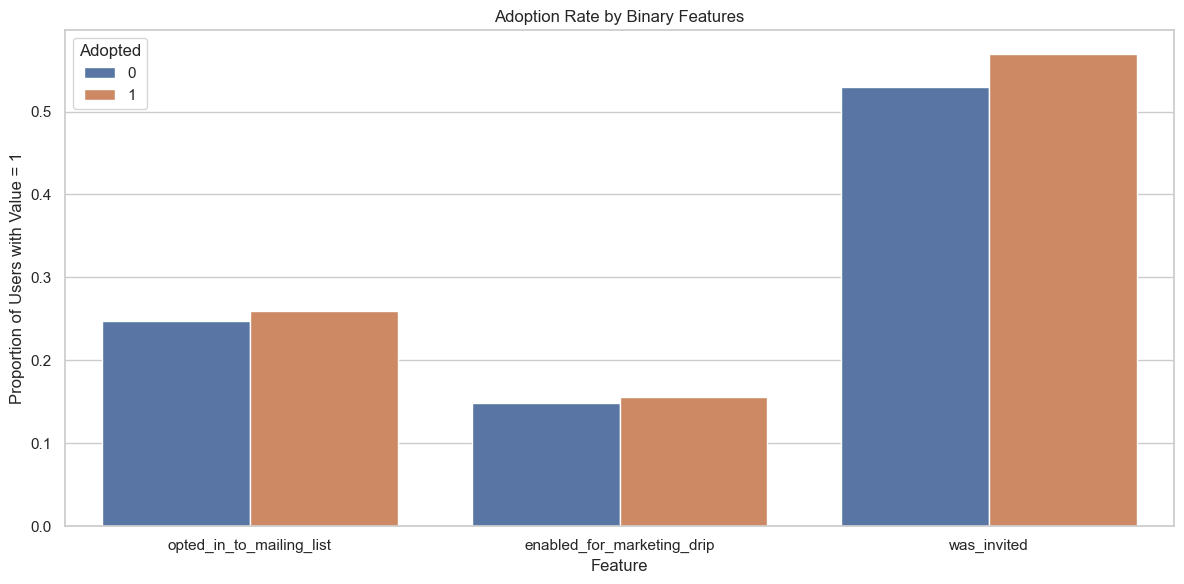

In [7]:
# Set up for plots
sns.set(style="whitegrid")

# Compare adoption rate across binary features
binary_features = ['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'was_invited']

# Melt the data to long format for better plotting
eda_df = feature_df[['adopted'] + binary_features].melt(id_vars='adopted', var_name='feature', value_name='value')

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=eda_df, x='feature', y='value', hue='adopted', errorbar=None)
plt.title("Adoption Rate by Binary Features")
plt.ylabel("Proportion of Users with Value = 1")
plt.xlabel("Feature")
plt.legend(title="Adopted")
plt.tight_layout()
plt.savefig('adoprtion_rate_binary_feats.png')
plt.show()

- Adopted users were much more likely to be invited by someone else.
- Not big differences between adopted and non-adopted users for the other 2 categories.

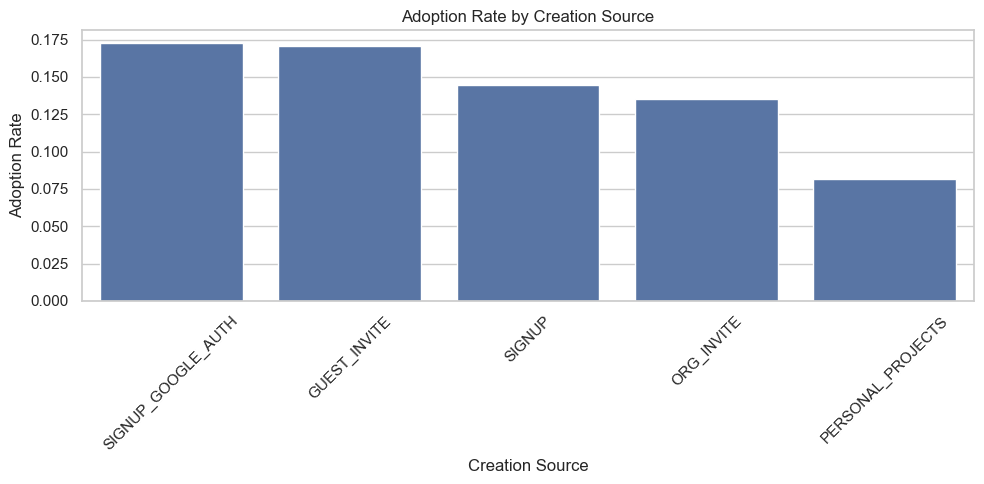

In [8]:
# Combine creation_source back with the adoption label for analysis
creation_source_df = merged_df[['creation_source', 'adopted']]

# Calculate adoption rate per creation source
creation_source_adoption = (
    creation_source_df.groupby('creation_source')['adopted']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=creation_source_adoption, x='creation_source', y='adopted')
plt.title("Adoption Rate by Creation Source")
plt.ylabel("Adoption Rate")
plt.xlabel("Creation Source")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('adopt_rate_creation_source.png')
plt.show()

- Users who signed up with Google Authentication are the most likely to become adopted. Possibly indicating tech-savvy users or lower friction onboarding.
- Guest invite is a close second, possibly indicating that offering low-friction guest experiences might be an effective way to introduce users to the product and drive quick engagement.

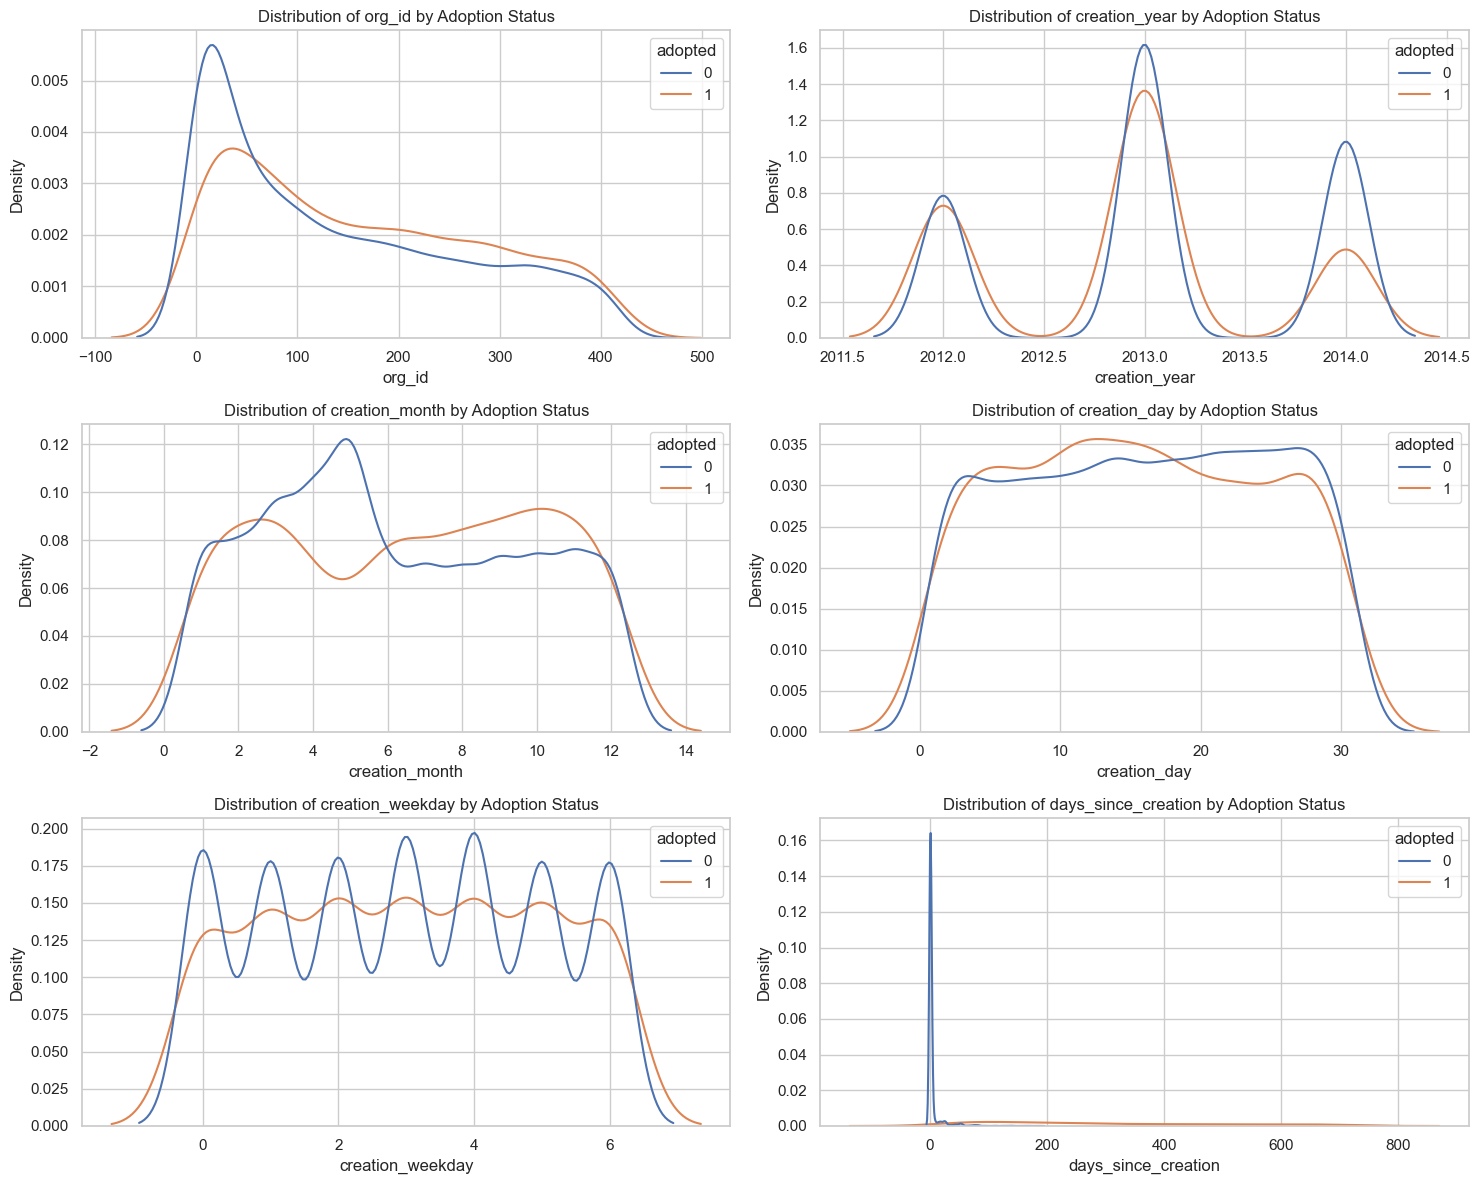

In [9]:
# List of numeric features to explore against adoption
numeric_features = [
    'org_id', 'creation_year', 'creation_month', 'creation_day',
    'creation_weekday', 'days_since_creation'
]

# Plot distribution of each numeric feature split by adoption
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    sns.kdeplot(data=feature_df, x=feature, hue='adopted', ax=axes[i], common_norm=False)
    axes[i].set_title(f"Distribution of {feature} by Adoption Status")

plt.tight_layout()
plt.savefig('adopt_status_num_feats.png')
plt.show()

- **orig_id** Some organization IDs have clusters of adopted useres, suggesting team effects orproduct fit for certain orginazations.
- **creation_month/day/year** show some slight bumps suggesting certain times have had more successful onboarding strategies or product iterations.
- **creation_weekday** looks to have a slight increase in adoption for users who sign up mid-week.
- **days_since_creation** shows that adopted users have longer activity spans than non-adopted users.

**Training and modeling**

Confusion Matrix:


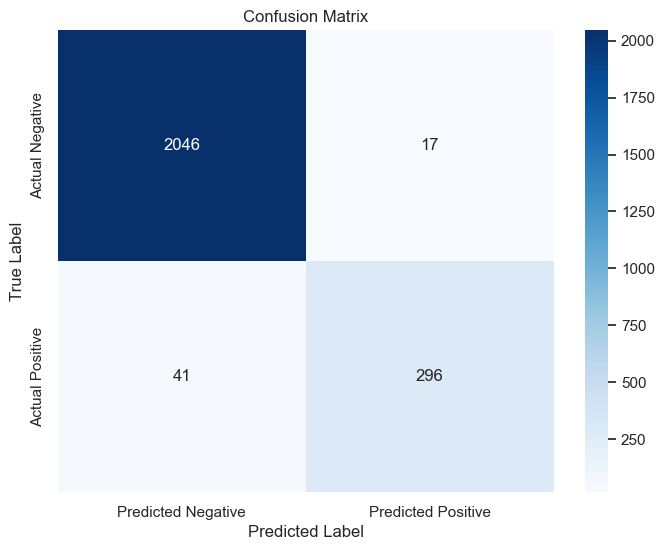

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Prepare feature matrix X and target vector y
X = feature_df.drop(columns='adopted')
y = feature_df['adopted']

# Standardize numerical features
numeric_cols = ['org_id', 'creation_year', 'creation_month', 'creation_day',
                'creation_weekday', 'days_since_creation']

scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Predictions and evaluation
y_pred = logreg.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)

# Coefficients as feature importance
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': logreg.coef_[0]
}).sort_values(by='coefficient', key=abs, ascending=False)


print('Confusion Matrix:')
# Create a heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('adoption_log_reg_conf_mtx.png')
plt.show()

In [11]:
print('Class Report:')
class_report

Class Report:


{'0': {'precision': 0.9803545759463345,
  'recall': 0.9917595734367426,
  'f1-score': 0.9860240963855421,
  'support': 2063.0},
 '1': {'precision': 0.9456869009584664,
  'recall': 0.8783382789317508,
  'f1-score': 0.9107692307692308,
  'support': 337.0},
 'accuracy': 0.9758333333333333,
 'macro avg': {'precision': 0.9630207384524004,
  'recall': 0.9350489261842467,
  'f1-score': 0.9483966635773864,
  'support': 2400.0},
 'weighted avg': {'precision': 0.9754866565834546,
  'recall': 0.9758333333333333,
  'f1-score': 0.9754570590052519,
  'support': 2400.0}}

In [12]:
coef_df

,feature,coefficient
7,days_since_creation,7.792713
11,source_PERSONAL_PROJECTS,-0.685231
3,creation_year,0.378064
12,source_SIGNUP,-0.374842
13,source_SIGNUP_GOOGLE_AUTH,-0.257970
10,source_ORG_INVITE,-0.197485
0,opted_in_to_mailing_list,0.194048
2,org_id,0.190400
8,was_invited,-0.174560
6,creation_weekday,0.121029


Model looks to perform very well and distinguishes adopted users with good precision and recall.